# statistical comparisons

Notebook to run post-hoc pairwise statistical comparisons between methods on the ground-truth and black-box regression problems.

In [1]:
from scipy.stats import wilcoxon 
import pandas as pd
import itertools as it
import os
import seaborn as sns
sns.set(font_scale=1.5, style='white')

figdir = 'figs/stats/'
rdir = '../results/'

print('figdir:',figdir)
def save(h=None,name='tmp'):
    name = name.strip().replace(' ','-').replace('%','pct')
    if h == None:
        h = plt.gcf()
    h.tight_layout()
    print('saving',figdir+'/'+name+'.png')
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    plt.savefig(figdir+'/'+name+'.png', bbox_inches='tight')

figdir: figs/stats/


In [2]:
import pdb
import numpy as np

def pairwise_pval(df, metric, alg1, alg2):
    df = df.loc[df.algorithm.isin([alg1, alg2]),:].copy()
    x = df.loc[df.algorithm==alg1, metric].values 
    y = df.loc[df.algorithm==alg2, metric].values 
    eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
    if metric.endswith('norm'):
        rmetric = metric.replace('norm','rank')
    else:
        rmetric = metric+'_rank'
    if rmetric not in df.columns:
        rmetric = metric
        
    x_rank = df.loc[df.algorithm==alg1, rmetric].values 
    y_rank = df.loc[df.algorithm==alg2, rmetric].values 
#     pdb.set_trace()
    if len(x) != len(y):
        print(alg1, len(x))
        print(alg2, len(y))
    assert len(x) == len(y)
#     w, p = mannwhitneyu(x, y)
    if all(y==0) and all(x==0):
        return 1, 1
    
    w, p = wilcoxon(x, y)
    return p, eff_size

#     return pstr, eff_size_str

def signif(pval, alpha, eff):
    pstr = '{:1.2g}'.format(pval)
    eff_size_str = '{:1.1f}X'.format(eff)
    if pval == '-': return pval
    if float(pval) < alpha:
        return 'textbf{'+pstr+'}', 'textbf{'+eff_size_str+'}'
#         return pval+'*'
    else:
        return pstr, eff_size_str
    
def get_pval_df(df, metric, all_algs):
    df = df.copy()
    n=0
    pvals = []
    for alg1, alg2 in it.combinations(all_algs, 2):
        pval, eff_size = pairwise_pval(df, metric, alg1, alg2)
        pvals.append(dict(
            alg1 = alg1,
            alg2 = alg2,
            eff_size = eff_size,
            pval = pval
        ))
        n += 1
    c_alpha = alpha/n


    print('n:',n,'c_alpha:',c_alpha) 
    df_pvals = pd.DataFrame.from_records(pvals)
    # df_pvals['pval_thresh'] = pd.cut(x=df_pvals['pval'], bins = [0, c_alpha, 1])
    df_pvals['pval_thresh'] = df_pvals['pval'].apply(lambda x: bin_pval(x, c_alpha))

    # significance
    df_pvals.loc[:,'pval_bold'] = df_pvals.apply(lambda x: signif(x['pval'], 
                                                                      c_alpha,
                                                                      x['eff_size'])[0],
                                                     axis=1
                                                    )
    df_pvals.loc[:,'eff_size_bold'] = df_pvals.apply(lambda x: signif(x['pval'], 
                                                                      c_alpha,
                                                                      x['eff_size'])[1],
                                                     axis=1
                                                    )
    return df_pvals, c_alpha

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

def bin_pval(x, c_alpha):

    for stars,level in zip([4,3,2,1],[1e-3, 1e-2, 1e-1, 1]):
        if x < level*c_alpha: 
            return stars #level #*c_alpha
    return 0

def pval_heatmap(df, metric, problem, algs):
    df = df.copy()
    n = 0 
    pvals = []

    df_pvals, c_alpha = get_pval_df(df, metric, algs)
    
    #                                                  pd.cut(x=df_pvals['pval'], bins = [0, c_alpha, 1])
    tbl = df_pvals.set_index(['alg1','alg2'])['pval_thresh'].unstack().transpose() #.fillna('-')

    mask = np.zeros_like(tbl, dtype=bool)
    mask[np.triu_indices_from(mask,k=1)] = True

    h = plt.figure(figsize=(10,10))

    cmap = sns.color_palette('flare',n_colors=5)
    cmap[0] = [.9, .9, .9]
    ax = sns.heatmap(tbl, 
                linewidth=0.25,
                mask=mask,
                square=True,
                cbar_kws=dict(
                              ticks = [0.4, 1.2, 2.0, 2.8, 3.6],
                              shrink=0.6,
                ),
                cmap=cmap,

               )
    cax = h.axes[-1]
    cbar_labels = [
                   'no significance',
                   '$p<\\alpha$',
                   '$p<$1e-1$\cdot \\alpha$',
                   '$p<$1e-2$\cdot \\alpha$',
                   '$p<$1e-3$\cdot \\alpha$',
                  ]
    cax.set_yticklabels(cbar_labels)
    nice_metric = metric.replace('%','pct').replace('_',' ').replace('R2','$$R^2$$').title()
    plt.title(('Wilcoxon signed-rank test, '
              +nice_metric
              +', $\\alpha =$ {:1.1e}').format(c_alpha)
             )
    plt.xlabel('')
    plt.ylabel('')
    savename = ('Pairwise comparison of '
              +nice_metric
              +' on '
              +problem).replace(' ','_')
    save(h, savename)

# symbolic datasets

## load data and fill nan results

In [4]:
df_sum = pd.read_csv(rdir+'/symbolic_dataset_results_sum.csv.gz')
algs = df_sum.algorithm.unique()
datasets = df_sum.dataset.unique()
noises = df_sum.target_noise.unique()

df_sum
cols = df_sum.columns
for col in [c for c in cols if 'rank' in c]:
    df_sum.loc[:,col] = df_sum[col].fillna(len(algs)+1)
for col in [c for c in cols if 'solution_rate' in c]:
    df_sum.loc[:,col] = df_sum[col].fillna(0.0)

In [5]:
cols = df_sum.columns
filler_frame = {
    'r2_test' : 0.0,
    'solution_rate_(%)' : 0.0,
}
fill_frames = []

for dataset in datasets:
    for noise in noises:
        for alg in algs:
            df = df_sum.loc[df_sum.dataset == dataset].loc[df_sum.target_noise==noise]
            if alg not in df.algorithm.unique():
                new_fill = filler_frame.copy()
                new_fill.update({
                                 'algorithm':alg,
                                 'dataset':dataset,
                                 'target_noise':noise
                                })
                fill_frames.append(new_fill)
df_fill = pd.DataFrame.from_records(fill_frames, columns=fill_frames[0].keys()) 
df_sum_filled = df_sum.append(df_fill)


/tmp/ipykernel_67286/151884592.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sum_filled = df_sum.append(df_fill)


## generate tables

In [6]:
alpha = 0.05
SR_pvals = {}

for metric in ['r2_test','symbolic_solution_rate','simplified_complexity']:
    for target_noise, dfg in df_sum_filled.groupby('target_noise'):
        print(metric, 'noise=',target_noise)
        df_pvals, c_alpha = get_pval_df(df_sum_filled, metric, algs) 

        pval_tbl = df_pvals.set_index(['alg1','alg2'])['pval_bold'].unstack().fillna('-')
        disp_tbl = df_pvals.set_index(['alg1','alg2'])['pval'].unstack().fillna('-')
        SR_pvals[metric] = {target_noise:disp_tbl}
        display(disp_tbl)

        pval_tbl

/tmp/ipykernel_67286/887026745.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))


r2_test noise= 0.0


/tmp/ipykernel_67286/887026745.py:8: RuntimeWarning: invalid value encountered in scalar divide
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))


n: 171 c_alpha: 0.00029239766081871346


alg2,AFP_FE,AIFeynman,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,,,,,,
AFP,0.0,0.000415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002851,0.0,0.0,0.0,0.037854,0.0,0.0,1.207877e-16
AFP_FE,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.673466,0.0,0.0,0.0,0.0,0.049753,0.0,0.0,3.201922e-60
AIFeynman,-,-,0.647376,0.0,0.0,0.0,0.0,0.0,0.020042,0.000004,0.000387,0.064769,0.0,0.008687,0.000004,0.0,0.0,3.657806e-02
BSR,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.477174e-26
Baseline,-,-,-,-,0.0,0.0,0.000394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.853691e-81
C-D-TS,-,-,-,-,-,0.001037,0.000014,0.27946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.857143e-74
C-D-UCB1,-,-,-,-,-,-,0.0,0.013413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.010214e-72
D-TS,-,-,-,-,-,-,-,0.044829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.346128e-80
D-UCB1,-,-,-,-,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.223412e-74


r2_test noise= 0.001


/tmp/ipykernel_67286/887026745.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
/tmp/ipykernel_67286/887026745.py:8: RuntimeWarning: invalid value encountered in scalar divide
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))


n: 171 c_alpha: 0.00029239766081871346


alg2,AFP_FE,AIFeynman,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,,,,,,
AFP,0.0,0.000415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002851,0.0,0.0,0.0,0.037854,0.0,0.0,1.207877e-16
AFP_FE,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.673466,0.0,0.0,0.0,0.0,0.049753,0.0,0.0,3.201922e-60
AIFeynman,-,-,0.647376,0.0,0.0,0.0,0.0,0.0,0.020042,0.000004,0.000387,0.064769,0.0,0.008687,0.000004,0.0,0.0,3.657806e-02
BSR,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.477174e-26
Baseline,-,-,-,-,0.0,0.0,0.000394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.853691e-81
C-D-TS,-,-,-,-,-,0.001037,0.000014,0.27946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.857143e-74
C-D-UCB1,-,-,-,-,-,-,0.0,0.013413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.010214e-72
D-TS,-,-,-,-,-,-,-,0.044829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.346128e-80
D-UCB1,-,-,-,-,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.223412e-74


r2_test noise= 0.01


/tmp/ipykernel_67286/887026745.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
/tmp/ipykernel_67286/887026745.py:8: RuntimeWarning: invalid value encountered in scalar divide
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))


n: 171 c_alpha: 0.00029239766081871346


alg2,AFP_FE,AIFeynman,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,,,,,,
AFP,0.0,0.000415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002851,0.0,0.0,0.0,0.037854,0.0,0.0,1.207877e-16
AFP_FE,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.673466,0.0,0.0,0.0,0.0,0.049753,0.0,0.0,3.201922e-60
AIFeynman,-,-,0.647376,0.0,0.0,0.0,0.0,0.0,0.020042,0.000004,0.000387,0.064769,0.0,0.008687,0.000004,0.0,0.0,3.657806e-02
BSR,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.477174e-26
Baseline,-,-,-,-,0.0,0.0,0.000394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.853691e-81
C-D-TS,-,-,-,-,-,0.001037,0.000014,0.27946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.857143e-74
C-D-UCB1,-,-,-,-,-,-,0.0,0.013413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.010214e-72
D-TS,-,-,-,-,-,-,-,0.044829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.346128e-80
D-UCB1,-,-,-,-,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.223412e-74


r2_test noise= 0.1


/tmp/ipykernel_67286/887026745.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
/tmp/ipykernel_67286/887026745.py:8: RuntimeWarning: invalid value encountered in scalar divide
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))


n: 171 c_alpha: 0.00029239766081871346


alg2,AFP_FE,AIFeynman,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,,,,,,
AFP,0.0,0.000415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002851,0.0,0.0,0.0,0.037854,0.0,0.0,1.207877e-16
AFP_FE,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.673466,0.0,0.0,0.0,0.0,0.049753,0.0,0.0,3.201922e-60
AIFeynman,-,-,0.647376,0.0,0.0,0.0,0.0,0.0,0.020042,0.000004,0.000387,0.064769,0.0,0.008687,0.000004,0.0,0.0,3.657806e-02
BSR,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.477174e-26
Baseline,-,-,-,-,0.0,0.0,0.000394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.853691e-81
C-D-TS,-,-,-,-,-,0.001037,0.000014,0.27946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.857143e-74
C-D-UCB1,-,-,-,-,-,-,0.0,0.013413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.010214e-72
D-TS,-,-,-,-,-,-,-,0.044829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.346128e-80
D-UCB1,-,-,-,-,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.223412e-74


symbolic_solution_rate noise= 0.0


/tmp/ipykernel_67286/887026745.py:8: RuntimeWarning: invalid value encountered in scalar divide
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))


n: 171 c_alpha: 0.00029239766081871346


/home/ch246537/.conda/envs/srbench-brush/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Sample size too small for normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


alg2,AFP_FE,AIFeynman,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,,,,,,
AFP,0.000006,-,0.0,-,-,-,-,-,0.363694,0.0,0.0,0.0,0.000001,0.0,0.0,0.0,0.0,-
AFP_FE,-,-,0.0,-,-,-,-,-,0.140275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-
AIFeynman,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
BSR,-,-,-,-,-,-,-,-,0.0,0.0,0.000203,0.000088,0.0,0.0,0.000079,0.0,0.0,-
Baseline,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


/tmp/ipykernel_67286/887026745.py:8: RuntimeWarning: invalid value encountered in scalar divide
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))


symbolic_solution_rate noise= 0.001
n: 171 c_alpha: 0.00029239766081871346


/home/ch246537/.conda/envs/srbench-brush/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Sample size too small for normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


alg2,AFP_FE,AIFeynman,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,,,,,,
AFP,0.000006,-,0.0,-,-,-,-,-,0.363694,0.0,0.0,0.0,0.000001,0.0,0.0,0.0,0.0,-
AFP_FE,-,-,0.0,-,-,-,-,-,0.140275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-
AIFeynman,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
BSR,-,-,-,-,-,-,-,-,0.0,0.0,0.000203,0.000088,0.0,0.0,0.000079,0.0,0.0,-
Baseline,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


/tmp/ipykernel_67286/887026745.py:8: RuntimeWarning: invalid value encountered in scalar divide
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))


symbolic_solution_rate noise= 0.01
n: 171 c_alpha: 0.00029239766081871346


/home/ch246537/.conda/envs/srbench-brush/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Sample size too small for normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


alg2,AFP_FE,AIFeynman,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,,,,,,
AFP,0.000006,-,0.0,-,-,-,-,-,0.363694,0.0,0.0,0.0,0.000001,0.0,0.0,0.0,0.0,-
AFP_FE,-,-,0.0,-,-,-,-,-,0.140275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-
AIFeynman,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
BSR,-,-,-,-,-,-,-,-,0.0,0.0,0.000203,0.000088,0.0,0.0,0.000079,0.0,0.0,-
Baseline,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


/tmp/ipykernel_67286/887026745.py:8: RuntimeWarning: invalid value encountered in scalar divide
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))


symbolic_solution_rate noise= 0.1
n: 171 c_alpha: 0.00029239766081871346


/home/ch246537/.conda/envs/srbench-brush/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Sample size too small for normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


alg2,AFP_FE,AIFeynman,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,,,,,,
AFP,0.000006,-,0.0,-,-,-,-,-,0.363694,0.0,0.0,0.0,0.000001,0.0,0.0,0.0,0.0,-
AFP_FE,-,-,0.0,-,-,-,-,-,0.140275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-
AIFeynman,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
BSR,-,-,-,-,-,-,-,-,0.0,0.0,0.000203,0.000088,0.0,0.0,0.000079,0.0,0.0,-
Baseline,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


simplified_complexity noise= 0.0
n: 171 c_alpha: 0.00029239766081871346


alg2,AFP_FE,AIFeynman,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,,,,,,
AFP,0.0,-,0.0,-,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,-,0.0,-,-
AFP_FE,-,-,0.252761,-,-,-,-,-,0.0,0.0,0.0,0.0,0.026123,0.0,-,0.0,-,-
AIFeynman,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
BSR,-,-,-,-,-,-,-,-,0.0,0.0,0.0,0.0,0.656002,0.0,-,0.0,-,-
Baseline,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


simplified_complexity noise= 0.001
n: 171 c_alpha: 0.00029239766081871346


alg2,AFP_FE,AIFeynman,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,,,,,,
AFP,0.0,-,0.0,-,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,-,0.0,-,-
AFP_FE,-,-,0.252761,-,-,-,-,-,0.0,0.0,0.0,0.0,0.026123,0.0,-,0.0,-,-
AIFeynman,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
BSR,-,-,-,-,-,-,-,-,0.0,0.0,0.0,0.0,0.656002,0.0,-,0.0,-,-
Baseline,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


simplified_complexity noise= 0.01
n: 171 c_alpha: 0.00029239766081871346


alg2,AFP_FE,AIFeynman,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,,,,,,
AFP,0.0,-,0.0,-,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,-,0.0,-,-
AFP_FE,-,-,0.252761,-,-,-,-,-,0.0,0.0,0.0,0.0,0.026123,0.0,-,0.0,-,-
AIFeynman,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
BSR,-,-,-,-,-,-,-,-,0.0,0.0,0.0,0.0,0.656002,0.0,-,0.0,-,-
Baseline,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


simplified_complexity noise= 0.1
n: 171 c_alpha: 0.00029239766081871346


alg2,AFP_FE,AIFeynman,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP-GP,gplearn
alg1,,,,,,,,,,,,,,,,,,
AFP,0.0,-,0.0,-,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,-,0.0,-,-
AFP_FE,-,-,0.252761,-,-,-,-,-,0.0,0.0,0.0,0.0,0.026123,0.0,-,0.0,-,-
AIFeynman,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
BSR,-,-,-,-,-,-,-,-,0.0,0.0,0.0,0.0,0.656002,0.0,-,0.0,-,-
Baseline,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
C-D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-TS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
D-UCB1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


## generate heatmaps

/tmp/ipykernel_67286/887026745.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
/tmp/ipykernel_67286/887026745.py:8: RuntimeWarning: invalid value encountered in scalar divide
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))


n: 171 c_alpha: 0.00029239766081871346
saving figs/stats//Pairwise_comparison_of_R2_Test_on_symbolic_problems_target_noise=0.0.png


/tmp/ipykernel_67286/887026745.py:8: RuntimeWarning: invalid value encountered in scalar divide
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
/tmp/ipykernel_67286/887026745.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
/home/ch246537/.conda/envs/srbench-brush/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Sample size too small for normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


n: 171 c_alpha: 0.00029239766081871346
saving figs/stats//Pairwise_comparison_of_Symbolic_Solution_Rate_on_symbolic_problems_target_noise=0.0.png
n: 171 c_alpha: 0.00029239766081871346
saving figs/stats//Pairwise_comparison_of_Simplified_Complexity_on_symbolic_problems_target_noise=0.0.png


/tmp/ipykernel_67286/887026745.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
/tmp/ipykernel_67286/887026745.py:8: RuntimeWarning: invalid value encountered in scalar divide
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))


n: 171 c_alpha: 0.00029239766081871346
saving figs/stats//Pairwise_comparison_of_R2_Test_on_symbolic_problems_target_noise=0.001.png


/tmp/ipykernel_67286/887026745.py:8: RuntimeWarning: invalid value encountered in scalar divide
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
/tmp/ipykernel_67286/887026745.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
/home/ch246537/.conda/envs/srbench-brush/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Sample size too small for normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


n: 171 c_alpha: 0.00029239766081871346
saving figs/stats//Pairwise_comparison_of_Symbolic_Solution_Rate_on_symbolic_problems_target_noise=0.001.png
n: 171 c_alpha: 0.00029239766081871346
saving figs/stats//Pairwise_comparison_of_Simplified_Complexity_on_symbolic_problems_target_noise=0.001.png


/tmp/ipykernel_67286/887026745.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
/tmp/ipykernel_67286/887026745.py:8: RuntimeWarning: invalid value encountered in scalar divide
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))


n: 171 c_alpha: 0.00029239766081871346
saving figs/stats//Pairwise_comparison_of_R2_Test_on_symbolic_problems_target_noise=0.01.png


/tmp/ipykernel_67286/887026745.py:8: RuntimeWarning: invalid value encountered in scalar divide
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
/home/ch246537/.conda/envs/srbench-brush/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Sample size too small for normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


n: 171 c_alpha: 0.00029239766081871346
saving figs/stats//Pairwise_comparison_of_Symbolic_Solution_Rate_on_symbolic_problems_target_noise=0.01.png
n: 171 c_alpha: 0.00029239766081871346
saving figs/stats//Pairwise_comparison_of_Simplified_Complexity_on_symbolic_problems_target_noise=0.01.png


/tmp/ipykernel_67286/887026745.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
/tmp/ipykernel_67286/887026745.py:8: RuntimeWarning: invalid value encountered in scalar divide
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))


n: 171 c_alpha: 0.00029239766081871346
saving figs/stats//Pairwise_comparison_of_R2_Test_on_symbolic_problems_target_noise=0.1.png


/tmp/ipykernel_67286/887026745.py:8: RuntimeWarning: invalid value encountered in scalar divide
  eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
/home/ch246537/.conda/envs/srbench-brush/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Sample size too small for normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


n: 171 c_alpha: 0.00029239766081871346
saving figs/stats//Pairwise_comparison_of_Symbolic_Solution_Rate_on_symbolic_problems_target_noise=0.1.png
n: 171 c_alpha: 0.00029239766081871346
saving figs/stats//Pairwise_comparison_of_Simplified_Complexity_on_symbolic_problems_target_noise=0.1.png


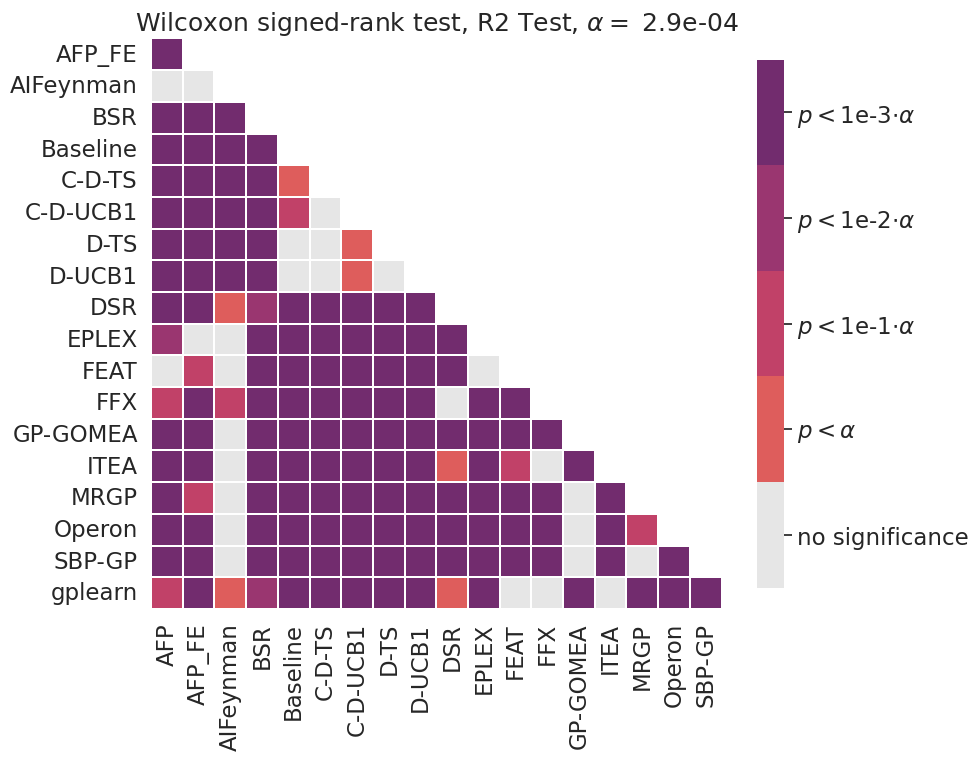

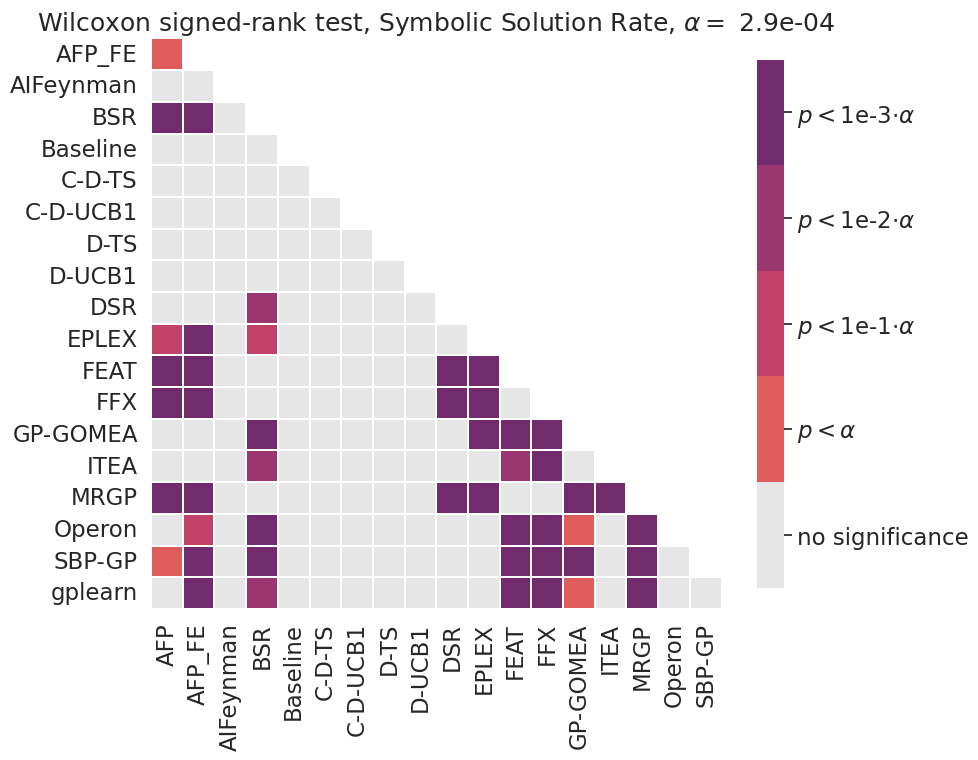

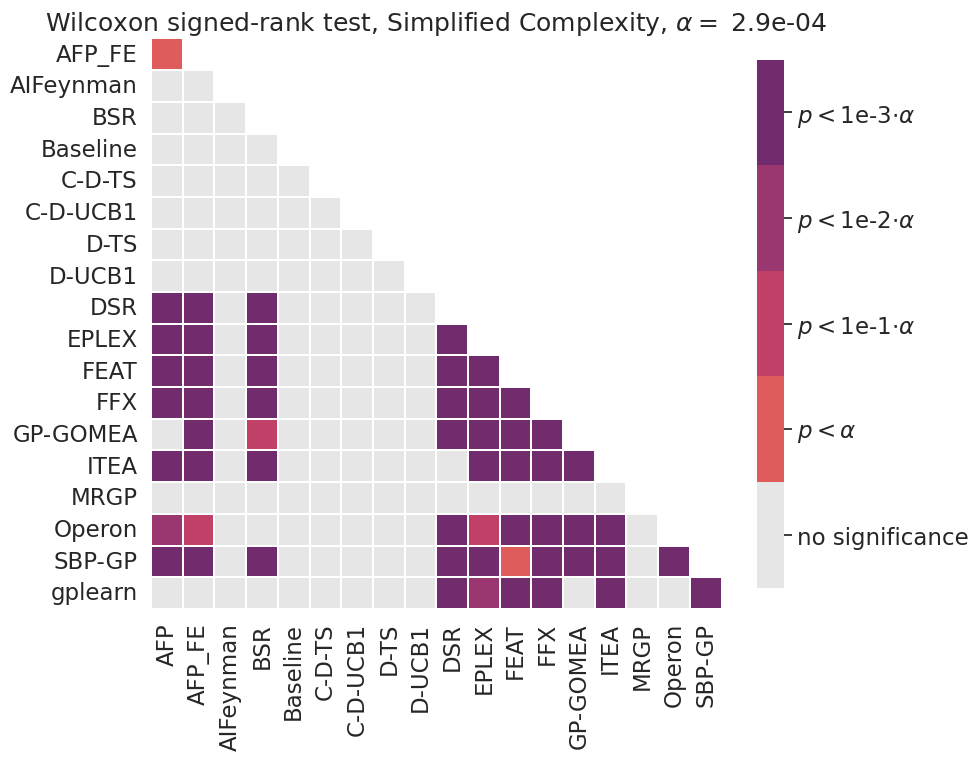

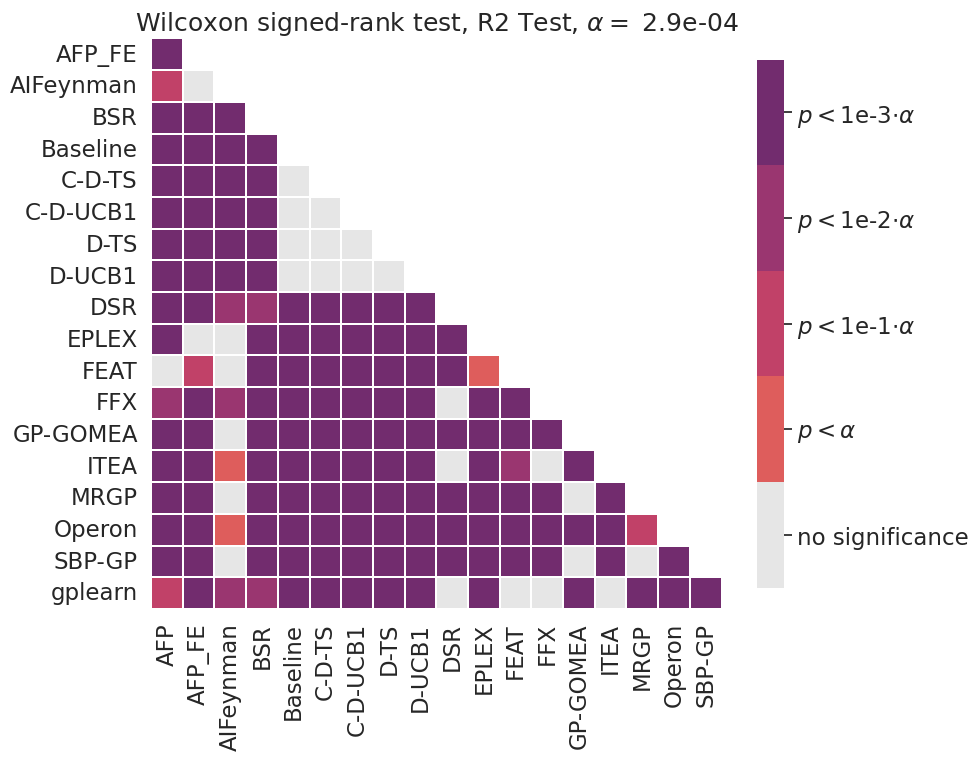

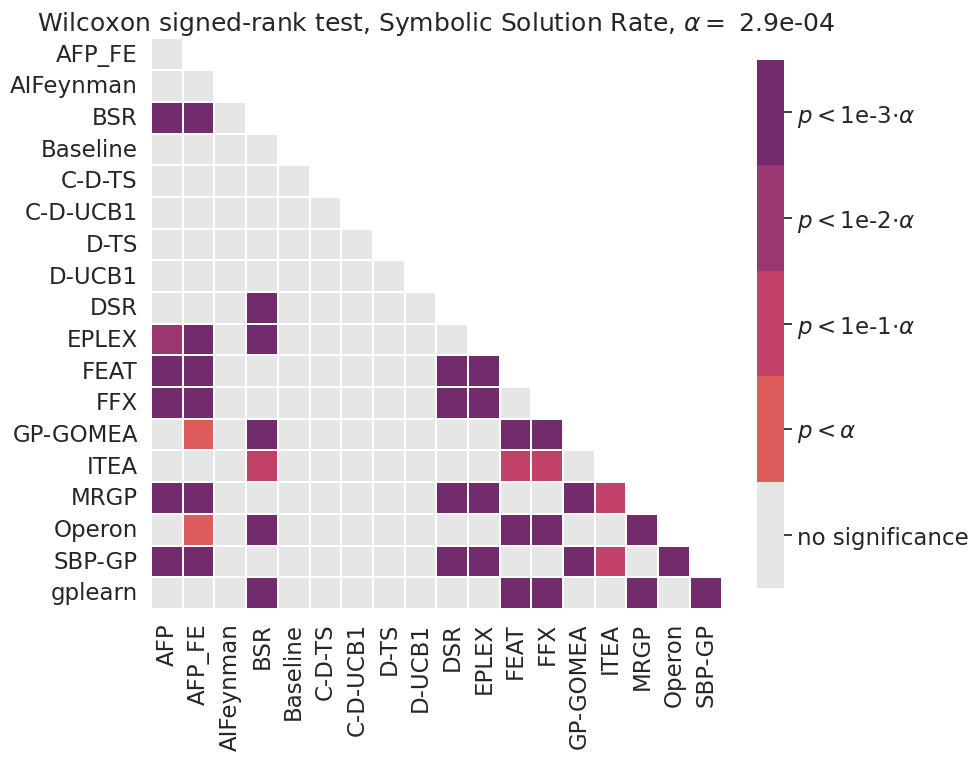

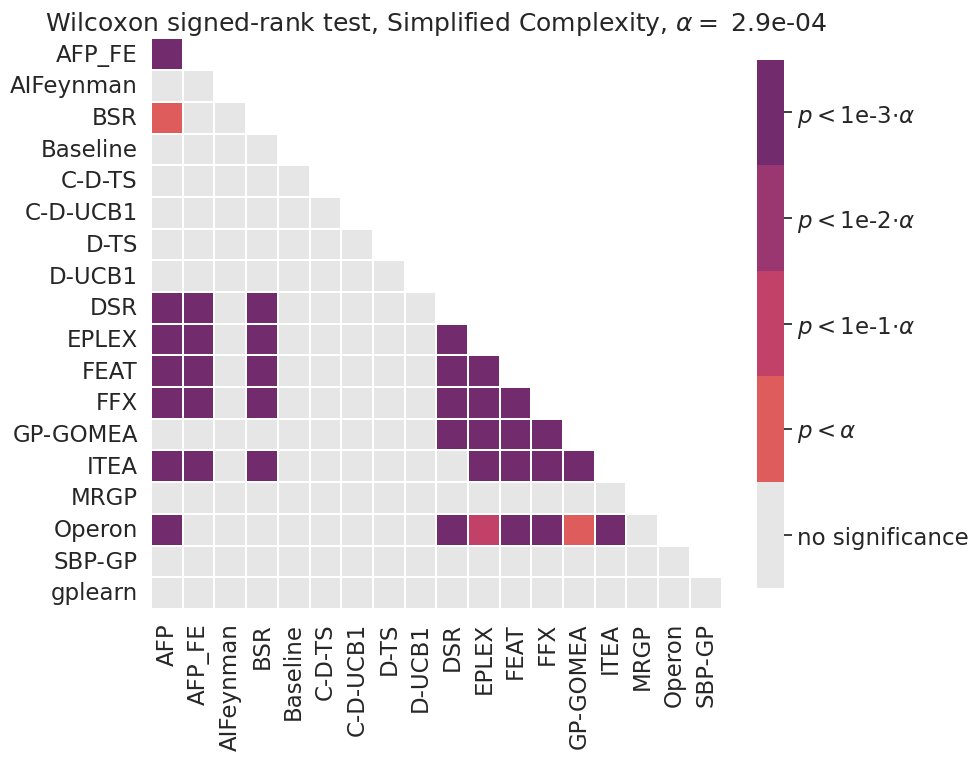

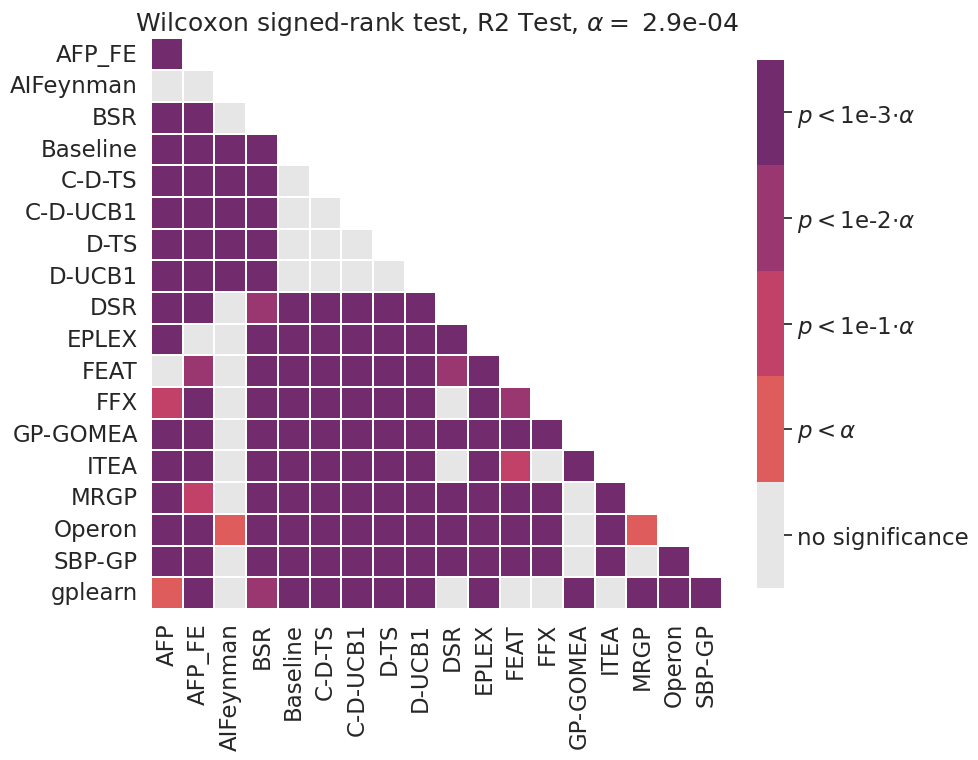

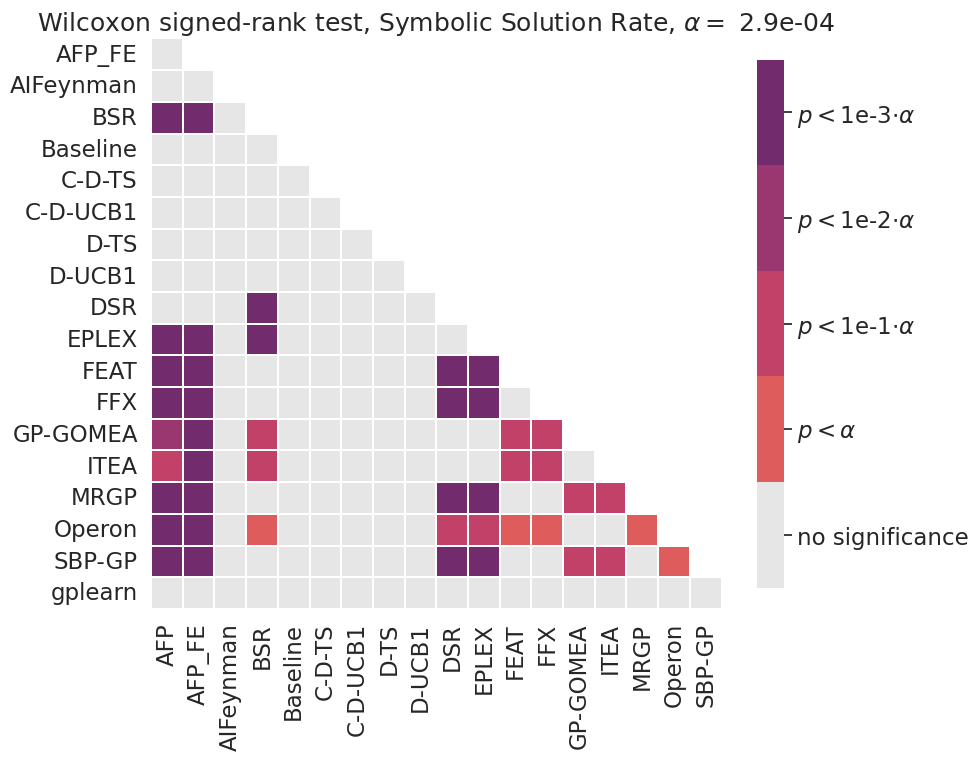

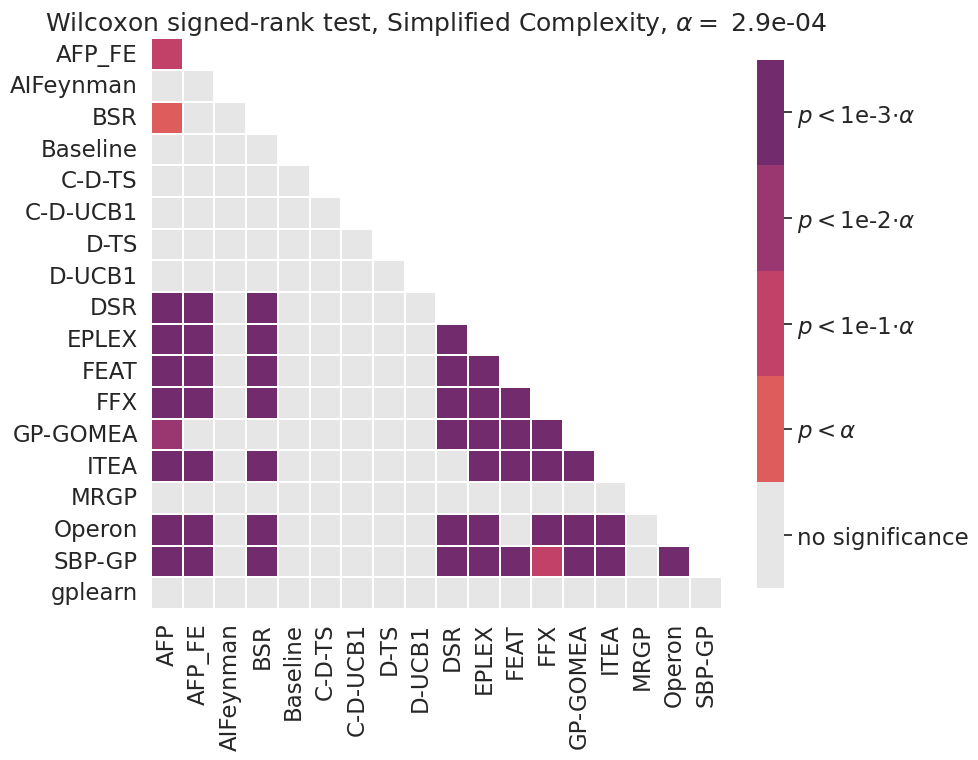

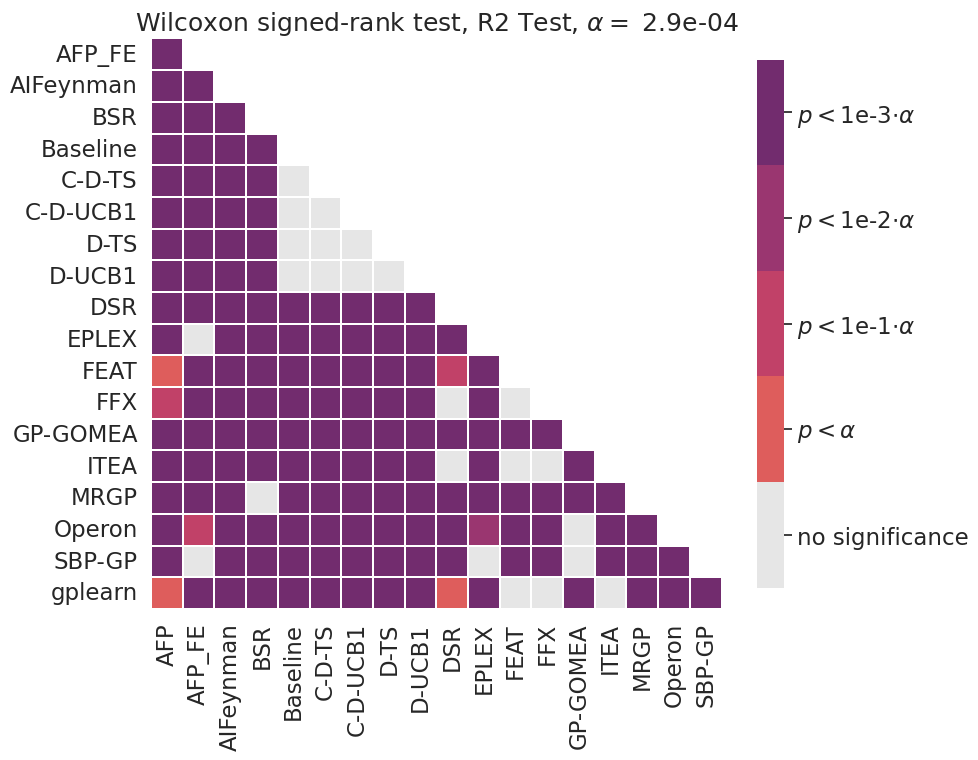

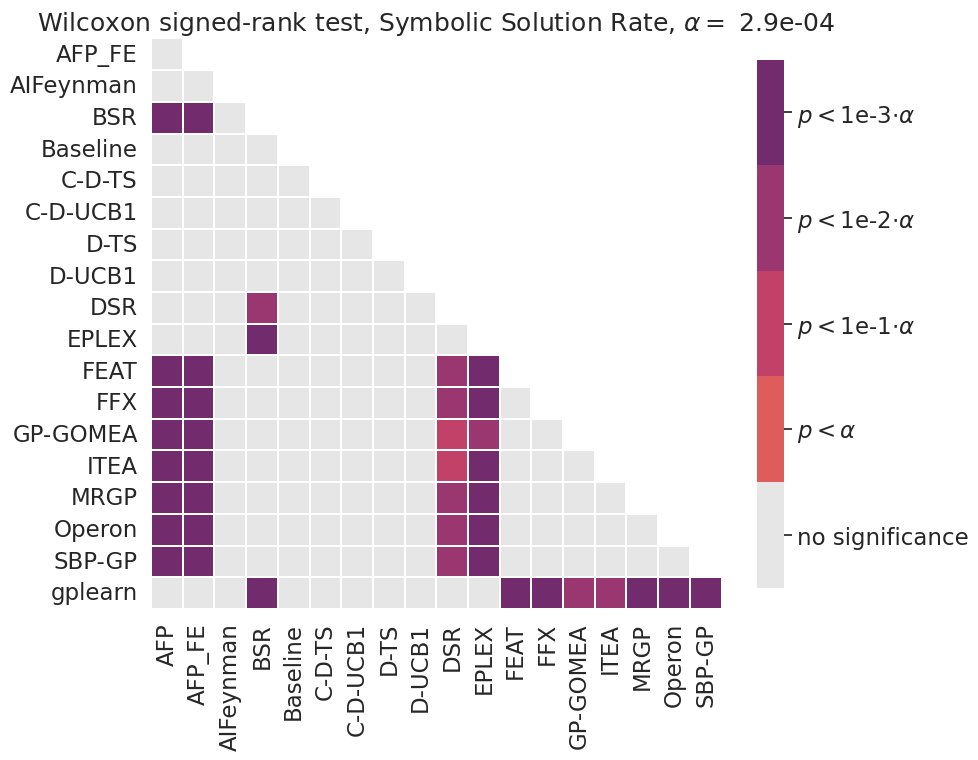

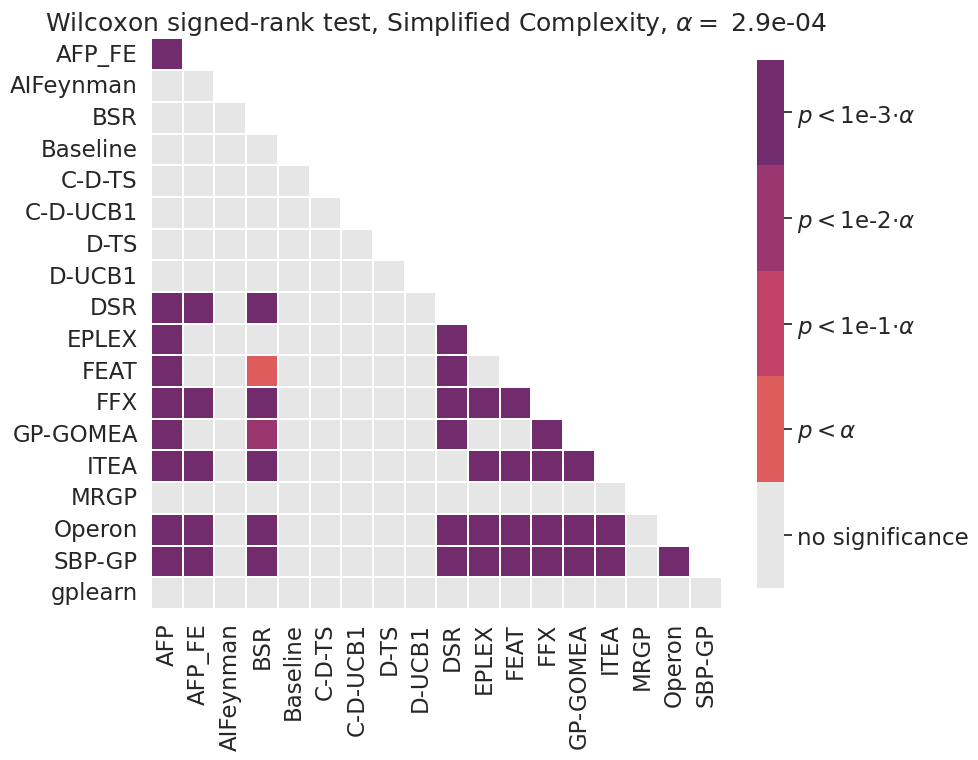

In [7]:
for target_noise, dfg in df_sum_filled.groupby('target_noise'):
    for metric in ['r2_test','symbolic_solution_rate','simplified_complexity']:
        name = 'symbolic problems target_noise='+str(target_noise)
        pval_heatmap(dfg, metric, name, algs)
    

# Black-Box datasets

## load data and fill nan results

In [8]:
df_sum = pd.read_csv(rdir+'/results_black-box_summary.csv.gz')
algs = df_sum.algorithm.unique()
datasets = df_sum.dataset.unique()

df_sum

,algorithm,dataset,random_state,training time (s),mse_test,mae_test,r2_test,model_size,training time (hr),r2_zero_test,...,r2_test_rank,r2_test_norm,model_size_rank,model_size_norm,r2_zero_test_rank,r2_zero_test_norm,rmse_test_rank,rmse_test_norm,log_mse_test_rank,log_mse_test_norm
0,AFP,1027_ESL,13879.5,1210.966865,0.365049,0.442612,0.830930,20.5,0.336380,0.830930,...,18.0,0.922184,10.0,0.000770,18.0,0.922184,19.0,0.139514,19.0,0.123830
1,AFP,1028_SWD,13879.5,3017.658321,0.438023,0.538419,0.314517,47.0,0.838238,0.314517,...,19.0,0.835045,14.0,0.000378,19.0,0.808090,21.0,0.216281,21.0,0.208446
2,AFP,1029_LEV,13879.5,2622.206193,0.433124,0.508817,0.521904,23.5,0.728391,0.521904,...,18.0,0.939429,10.5,0.000229,18.0,0.934869,18.0,0.075124,18.0,0.070675
3,AFP,1030_ERA,13879.5,3007.024177,2.496171,1.299746,0.358716,36.5,0.835284,0.358716,...,18.0,0.919178,15.0,0.003315,18.0,0.917586,16.0,0.066810,16.0,0.070855
4,AFP,1089_USCrime,13879.5,590.939726,549.423049,18.823004,0.639671,25.0,0.164150,0.639671,...,21.0,0.822717,12.0,0.001007,21.0,0.780937,20.0,0.200320,20.0,0.286474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3134,gplearn,695_chatfield_4,13879.5,28398.484904,311.234213,11.696317,0.843542,1.0,7.888468,0.843542,...,5.0,0.997885,1.0,0.000000,5.0,0.974512,10.0,0.010673,10.0,0.038788
3135,gplearn,706_sleuth_case1202,13879.5,22506.032915,3185.450642,40.642813,0.661283,11.5,6.251676,0.661283,...,2.0,0.999864,8.0,0.001220,2.0,0.994737,3.0,0.009024,3.0,0.029265
3136,gplearn,712_chscase_geyser1,13879.5,26863.988673,36.237705,4.901875,0.760493,3.0,7.462219,0.760493,...,5.0,0.995754,3.0,0.000006,5.0,0.993841,1.0,0.000000,1.0,0.000000
3137,gplearn,banana,13879.5,31580.997657,0.421351,0.430139,0.571803,33.5,8.772499,0.571803,...,13.0,0.898714,6.0,0.000031,13.0,0.786982,13.0,0.158092,13.0,0.142943


In [9]:
# if a result is missing, assign it the worst ranking
# cols = df_sum.columns
filler_frame = {
    'r2_test_rank' : len(algs)+1,
    'model_size_rank' : len(algs)+1,
}
fill_frames = []
j = 0
for dataset in datasets:
    for alg in algs:
        df = df_sum.loc[df_sum.dataset == dataset]
        if alg not in df.algorithm.unique():
            print('filling',alg,'missing for',dataset)
#                 for col in cols:
            new_fill = filler_frame.copy()
            new_fill.update({
                             'algorithm':alg,
                             'dataset':dataset,
                            })
            print(new_fill)
            fill_frames.append(new_fill)
            j += 1
            
df_fill = pd.DataFrame.from_records(fill_frames, columns=fill_frames[0].keys()) 
df_sum_filled = df_sum.append(df_fill)


filling AIFeynman missing for 1191_BNG_pbc
{'r2_test_rank': 27, 'model_size_rank': 27, 'algorithm': 'AIFeynman', 'dataset': '1191_BNG_pbc'}
filling Baseline missing for 1191_BNG_pbc
{'r2_test_rank': 27, 'model_size_rank': 27, 'algorithm': 'Baseline', 'dataset': '1191_BNG_pbc'}
filling C-D-TS missing for 1191_BNG_pbc
{'r2_test_rank': 27, 'model_size_rank': 27, 'algorithm': 'C-D-TS', 'dataset': '1191_BNG_pbc'}
filling C-D-UCB1 missing for 1191_BNG_pbc
{'r2_test_rank': 27, 'model_size_rank': 27, 'algorithm': 'C-D-UCB1', 'dataset': '1191_BNG_pbc'}
filling D-TS missing for 1191_BNG_pbc
{'r2_test_rank': 27, 'model_size_rank': 27, 'algorithm': 'D-TS', 'dataset': '1191_BNG_pbc'}
filling D-UCB1 missing for 1191_BNG_pbc
{'r2_test_rank': 27, 'model_size_rank': 27, 'algorithm': 'D-UCB1', 'dataset': '1191_BNG_pbc'}
filling Baseline missing for 1196_BNG_pharynx
{'r2_test_rank': 27, 'model_size_rank': 27, 'algorithm': 'Baseline', 'dataset': '1196_BNG_pharynx'}
filling C-D-TS missing for 1196_BNG_phar

/tmp/ipykernel_67286/181780491.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sum_filled = df_sum.append(df_fill)


## generate tables

In [10]:
# baseline significance threshold; adjusted for no. of comparisons below
alpha = 0.05
BB_pvals = {}

for metric in ['r2_test','model_size']:
    pvals = []

    n = 0 
    df_pvals, c_alpha = get_pval_df(df_sum_filled, metric, algs) 
    pval_tbl = df_pvals.set_index(['alg1','alg2'])['pval'].unstack() 
    BB_pvals[metric] = pval_tbl.copy() 
    pval_tbl = pval_tbl.fillna('-')
    display(pval_tbl)
   
    pval_tbl

n: 325 c_alpha: 0.00015384615384615385


alg2,AFP_FE,AIFeynman,AdaBoost,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,...,KernelRidge,LGBM,Linear,MLP,MRGP,Operon,RandomForest,SBP-GP,XGB,gplearn
alg1,,,,,,,,,,,,,,,,,,,,,
AFP,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
AFP_FE,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
AIFeynman,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
AdaBoost,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
BSR,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
Baseline,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
C-D-TS,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
C-D-UCB1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
D-TS,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


n: 325 c_alpha: 0.00015384615384615385


alg2,AFP_FE,AIFeynman,AdaBoost,BSR,Baseline,C-D-TS,C-D-UCB1,D-TS,D-UCB1,DSR,...,KernelRidge,LGBM,Linear,MLP,MRGP,Operon,RandomForest,SBP-GP,XGB,gplearn
alg1,,,,,,,,,,,,,,,,,,,,,
AFP,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
AFP_FE,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
AIFeynman,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
AdaBoost,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
BSR,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
Baseline,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
C-D-TS,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
C-D-UCB1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
D-TS,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


n: 325 c_alpha: 0.00015384615384615385
saving figs/stats//Pairwise_comparison_of_R2_Test_on_black-box_problems.png
n: 325 c_alpha: 0.00015384615384615385
saving figs/stats//Pairwise_comparison_of_Model_Size_on_black-box_problems.png


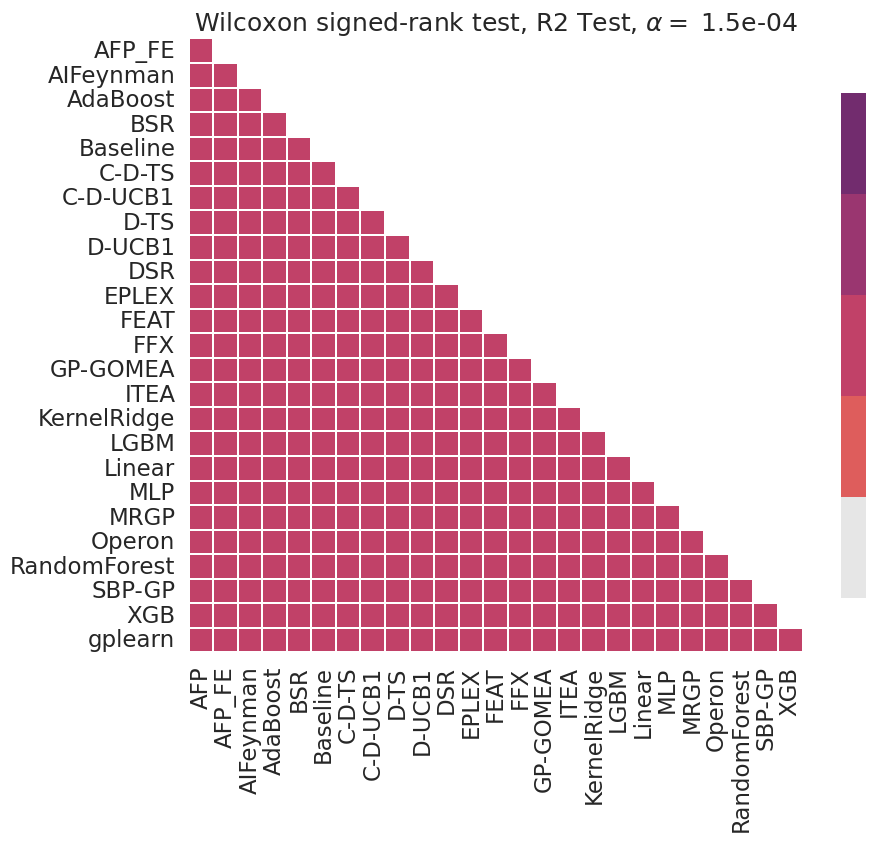

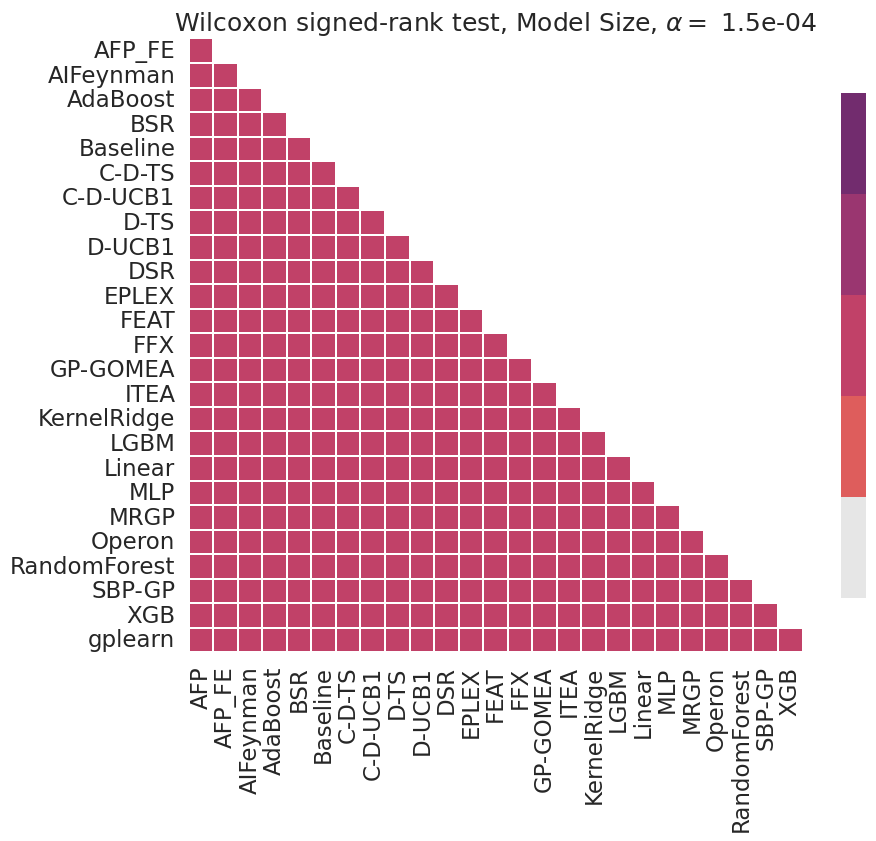

In [11]:
for metric in ['r2_test','model_size']:
    name = 'black-box problems'
    pval_heatmap(df_sum_filled, metric, name, algs)

## specific p-values referenced in manuscript

In [12]:
# first fill the matrices so we can look at either pair
for k,v in BB_pvals.items():
    algs = v.columns
    for alg1, alg2 in it.combinations(algs,2):
        if np.isnan(BB_pvals[k].loc[alg1,alg2]): 
            BB_pvals[k].loc[alg1,alg2] = BB_pvals[k].loc[alg2,alg1] 
        else:
            BB_pvals[k].loc[alg2,alg1] = BB_pvals[k].loc[alg1,alg2] 

KeyError: 'gplearn'

Operon performance on BB problems

In [ ]:
BB_pvals['r2_test']['Operon'].max() 

FEAT model size vs SGP

In [ ]:
BB_pvals['model_size'].loc['FEAT','SBP-GP']

Operon, SBP significantly outperform LGBM

In [ ]:
BB_pvals['r2_test'].loc['XGB',['Operon','SBP-GP']].max() #.replace('-','0').astype(float).max() #.round(2)

Operon, SBP, and FEAT significantly outperform LGBM

In [ ]:
BB_pvals['r2_test'].loc['LGBM',['Operon','FEAT','SBP-GP']].max() #.replace('-','0').astype(float).max() #.round(2)

GP models smaller than ensemble tree methods

In [ ]:
import itertools as it
import numpy as np

gps = ['Operon','FEAT','EPLEX','ITEA','GP-GOMEA']
trees = ['LGBM','XGB','RandomForest','AdaBoost']
BB_pvals['model_size'].loc[gps,trees].max().max()


In [ ]:
BB_pvals['r2_test'].loc[['DSR','BSR','FFX','AIFeynman'],['DSR','BSR','FFX','AIFeynman']]

In [ ]:
BB_pvals['r2_test'].loc[['DSR','FFX'],['BSR','AIFeynman']]

In [ ]:
BB_pvals['r2_test'][['BSR','AIFeynman']]